In [ ]:
!pip install implicit lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.5 MB 1.3 MB/s 
     |████████████████████████████████| 310 kB 59.8 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705372 sha256=521aa3d747e3c21aededd81711203572fa8739de9345b7e0b48530f1ebb0df8a
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
from datetime import date
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

from lightfm import LightFM
from lightfm import evaluation

## Метрики оценки качества модели
### Precision

*Precision* - доля релевантных товаров среди рекомендованных = Какой % рекомендованных товаров  юзер купил

- Пожалуй, самая приближенная к бизнес-метрикам и самая популярная метрика

---

Precision= (# of recommended items that are relevant) / (# of recommended items)  

Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

Money Precision@k = (revenue of recommended items @k that are relevant) / (revenue of recommended items @k)  

**Note:** Обычно k в precision@k достаточно невелико (5-20) и определяется из бизнес-логики. Например, 5 товаров в e-mail рассылке, 20 ответов на первой странице google и т.д

### Recall

*Recall* - доля рекомендованных товаров среди релевантных = Какой % купленных товаров был среди рекомендованных

- Обычно используется для моделей пре-фильтрации товаров (убрать те товары, которые точно не будем рекомендовать)

---

Recall= (# of recommended items that are relevant) / (# of relevant items)  

Recall@k = (# of recommended items @k that are relevant) / (# of relevant items)

Money Recall@k = (revenue of recommended items @k that are relevant) / (revenue of relevant items)  

    
  
**Note:** в recall@k число k обычно достаточно большое (50-200), больше чем покупок у среднестатистического юзера

In [ ]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    return precision


def recall_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])
    
    flags = np.isin(bought_list, recommended_list)
    recall = flags.sum() / len(bought_list)
    
    return recall

In [ ]:
df = pd.read_excel("Датасет5.xlsx")
df.head(2)

,Taskid,Дата заключения договора,Клиент,Сумма договора,Дата создания,Cтатус,ID статуса,Завершено,Валюта,Дата закрытия,Дата начала действия,Дата окончания,Лицензии,Лицензий всего,Оплачено,Первичный договор(да или нет),Период,Сумма договора.1,Тип договора,Форма договора,Рейтинг приоритетности клиента,Штат шкала,Штат - id шкалы штата,Используют ли услуги тех.поддержки,Сегменты компании,Отрасли компании,"Оборот, млн руб",Штат (число),Рейтинг
0,1092026,2022-05-12 00:00:00.000,146933,25000.0,2022-05-12 14:34:02,Ждем от клиента,942,0,RUR,NaN,2022-05-12 00:00:00.000,NaN,0.0,NaN,NaN,0,NaN,0.0,Обучение,NaN,NaN,от 100 до 500,433670.0,Да,Услуги,"Гос. сектор, Наука, образование",800.14,400.0,А
1,1092413,NaN,502179,0.0,2022-05-13 11:34:28,Новая,1,0,RUR,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,0.0,Обучение,NaN,NaN,NaN,NaN,Нет,Строительство,Бытовая химия,NaN,NaN,NaN


## Обзор данных в датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Taskid                              1670 non-null   int64         
 1   Дата заключения договора            1194 non-null   object        
 2   Клиент                              1670 non-null   int64         
 3   Сумма договора                      1494 non-null   float64       
 4   Дата создания                       1670 non-null   datetime64[ns]
 5   Cтатус                              1670 non-null   object        
 6   ID статуса                          1670 non-null   int64         
 7   Завершено                           1670 non-null   int64         
 8   Валюта                              1578 non-null   object        
 9   Дата закрытия                       151 non-null    object        
 10  Дата начала действия    

In [ ]:
clients, items, interactions = df['Клиент'].nunique(), df['Тип договора'].nunique(), df.shape[0]

print('# clients: ', clients)
print('# services: ', items)
print('# interactions: ', interactions)
print('# period:', df['Дата создания'].dt.date.min(), '-', df['Дата создания'].dt.date.max())

# clients:  438
# services:  13
# interactions:  1670
# period: 2008-07-10 - 2022-05-19


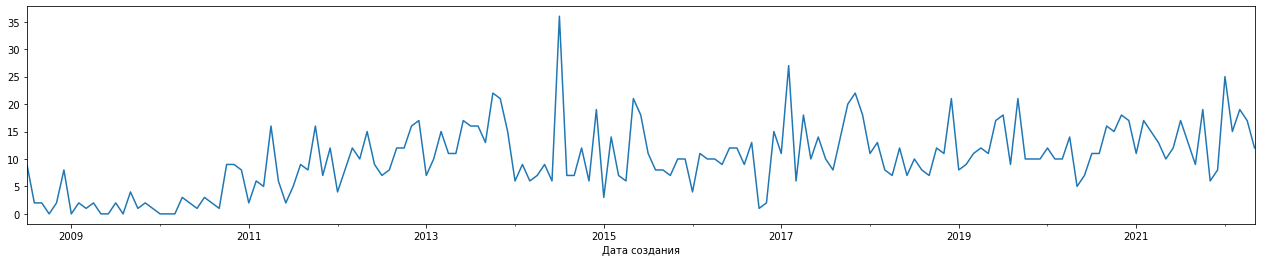

In [ ]:
plt.rcParams["figure.figsize"] = (22,4)
df.set_index('Дата создания').resample('1M')['Taskid'].count().plot()
plt.show()

In [ ]:
# Суммы договоров с клиентами:
df.groupby('Тип договора')['Сумма договора.1'].sum().sort_values(ascending=False).astype(int)

Тип договора
Лицензии                             159032288
Услуги                                81089480
ТП                                    17727015
SLA                                    9752958
Аренда сервера                         1190000
SAAS                                    833666
NDA                                          0
SAAS (подписка+аренда сервера+ТП)            0
SAAS мобильный                               0
Обучение                                     0
Партнер                                      0
Поставщик                                    0
Тестовая эксплуатация                        0
Name: Сумма договора.1, dtype: int64

## Трейн/тест

Разобъем датасет на трейн и тест примерно 80%/20% по дате создания записи:

In [ ]:
# Переименуем используемые признаки в датасете
data = df.rename(columns={'Клиент': 'clients', 'Тип договора': 'services', 'Сумма договора.1': 'sales_value'})
data['services'] = data['services'].fillna('unknown service')
data['services_id'] = data['services'].astype('category').cat.codes
data['services_id'].unique()

array([ 8,  4, 11,  7, 13,  6, 12,  1,  0,  9,  3, 10,  5,  2], dtype=int8)

In [ ]:
sep_date = date(2020, 6, 1)

data_train = data.loc[data['Дата создания'].dt.date < sep_date]
data_test = data.loc[data['Дата создания'].dt.date >= sep_date]
data_train.shape[0], data_test.shape[0]

(1337, 333)

## Бейзлайны

Создадим датафрейм с услугами клиентов на тестовом датасете

In [ ]:
result = data_test.groupby('clients')['services'].unique().reset_index()
result.columns=['clients', 'actual']
result.head(5)

,clients,actual
0,4630,[Услуги]
1,5568,"[ТП, Лицензии]"
2,5774,[ТП]
3,5775,[ТП]
4,5811,[SLA]


In [ ]:
test_clients = result.shape[0]
new_test_clients = len(set(data_test['clients']) - set(data_train['clients']))

print('Всего клиентов:', clients)
print(f'В тестовом датасете {test_clients} клиентов')
print(f'Из них {new_test_clients} новых клиентов')

Всего клиентов: 438
В тестовом датасете 130 клиентов
Из них 58 новых клиентов


### Рандомные рекомендации:

In [ ]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [ ]:
%%time

items = data_train.services.unique()

result['random_recommendation'] = result['clients'].apply(lambda x: random_recommendation(items, n=5))

CPU times: user 4.44 ms, sys: 0 ns, total: 4.44 ms
Wall time: 4.45 ms


In [ ]:
result.head(2)

,clients,actual,random_recommendation
0,4630,[Услуги],"[Лицензии, SLA, Партнер, Услуги, SAAS]"
1,5568,"[ТП, Лицензии]","[SLA, Тестовая эксплуатация, Партнер, SAAS моб..."


### Рекомендации популярных услуг

In [ ]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('services')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n)['services']
    
    return recs.tolist()

In [ ]:
%%time

popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['clients'].apply(lambda x: popular_recs)

CPU times: user 4.31 ms, sys: 366 µs, total: 4.68 ms
Wall time: 4.35 ms


In [ ]:
result.head(2)

,clients,actual,random_recommendation,popular_recommendation
0,4630,[Услуги],"[Лицензии, SLA, Партнер, Услуги, SAAS]","[Лицензии, Услуги, ТП, SLA, Аренда сервера]"
1,5568,"[ТП, Лицензии]","[SLA, Тестовая эксплуатация, Партнер, SAAS моб...","[Лицензии, Услуги, ТП, SLA, Аренда сервера]"


### Измерим качество бейзлайнов по precision@5 и recall@5

In [ ]:
def pr_at_k(x):
    res_lst = []
    for a in algs:
        res_lst.append(precision_at_k(x[a], x['actual']))
    return res_lst
    
def rc_at_k(x):
    res_lst = []
    for a in algs:
        res_lst.append(recall_at_k(x[a], x['actual']))
    return res_lst

In [ ]:
algs = set(list(result.columns)[2:])
algs

{'popular_recommendation', 'random_recommendation'}

In [ ]:
result['presicion_at_5'] = result.apply(pr_at_k, axis=1)
result['recall_at_5'] = result.apply(rc_at_k, axis=1)

In [ ]:
result.head(2)

,clients,actual,random_recommendation,popular_recommendation,presicion_at_5,recall_at_5
0,4630,[Услуги],"[Тестовая эксплуатация, SAAS, ТП, NDA, Лицензии]","[Лицензии, Услуги, ТП, SLA, Аренда сервера]","[0.0, 0.2]","[0.0, 1.0]"
1,5568,"[ТП, Лицензии]","[SAAS мобильный, SAAS, Партнер, ТП, Тестовая э...","[Лицензии, Услуги, ТП, SLA, Аренда сервера]","[0.2, 0.4]","[0.5, 1.0]"


In [ ]:
pat5_cols = ['p_at_5_' + x for x in algs]
rat5_cols = ['r_at_5_' + x for x in algs]
result[pat5_cols] = pd.DataFrame(result['presicion_at_5'].tolist(), index=result.index)
result[rat5_cols] = pd.DataFrame(result['recall_at_5'].tolist(), index=result.index)
result.describe().iloc[1, 1:]

p_at_5_popular_recommendation    0.318462
p_at_5_random_recommendation     0.167692
r_at_5_popular_recommendation    0.812949
r_at_5_random_recommendation     0.426410
Name: mean, dtype: float64

Как видно выше, по обоим метрикам, бейзлайн "Рекомендация ТОП5 услуг" имеет более высокие показатели.

## Коллаборативная фильтрация

Создадим user-item матрицу, необходимую для подачи в модель для implicit

In [ ]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='clients', 
                                  columns='services_id', 
                                  values='Taskid',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

# переведем в формат saprse matrix
user_item_matrix = user_item_matrix.astype(float)
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(5)

services_id,0,1,3,4,6,7,9,11,12,13
clients,,,,,,,,,,
217,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1383,0.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,0.0,2.0
4630,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,4.0
5568,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,7.0


In [ ]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

# id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))
serv_dict = data.groupby(['services_id','services']).size().reset_index().set_index('services_id')['services'].to_dict()
id_to_itemid = dict(zip(matrix_itemids, [serv_dict[v] for v in itemids]))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [ ]:
%%time

model = AlternatingLeastSquares(factors=100,  # Нужно подбирать
                                regularization=0.001,
                                iterations=25,
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 7.25 s, sys: 18.7 s, total: 25.9 s
Wall time: 13.5 s


In [ ]:
def get_recommendations(user, model, N=5):
    userid = userid_to_id.get(user, None)
    if userid:
        res = [id_to_itemid[itemid] for itemid in 
                        model.recommend(userid=userid, 
                                        user_items=sparse_user_item[userid],
                                        N=N,                                         
                                        filter_already_liked_items=False,
                                        recalculate_user=True,
                                        )[0]
            ]
        return res
    # Если клиент новый, то ему рекомендуем популярные item
    return popularity_recommendation(data_train, n=N)

In [ ]:
rec = model.recommend(userid=userid_to_id[217], 
                                    user_items=sparse_user_item[userid_to_id[217]],   # на вход user-item matrix
                                    N=5, 
                                    recalculate_user=True
                )
rec

(array([4, 0, 6, 1, 2], dtype=int32),
 array([0.00156336, 0.00136791, 0.00090945, 0.00082995, 0.00063652],
       dtype=float32))

In [ ]:
%%time
    
result['als'] = result['clients'].apply(lambda x: get_recommendations(x, model=model, N=5))

CPU times: user 192 ms, sys: 135 ms, total: 327 ms
Wall time: 178 ms


In [ ]:
result.head(2)

,clients,actual,random_recommendation,popular_recommendation,presicion_at_5,recall_at_5,p_at_5_random_recommendation,p_at_5_popular_recommendation,r_at_5_random_recommendation,r_at_5_popular_recommendation,als,p_at_5_als,r_at_5_als
0,4630,[Услуги],"[Лицензии, SLA, Партнер, Услуги, SAAS]","[Лицензии, Услуги, ТП, SLA, Аренда сервера]","[0.2, 0.2, 0.0]","[1.0, 1.0, 0.0]",0.2,0.2,1.0,1.0,"[Услуги, Лицензии, ТП, Аренда сервера, NDA]",0.0,0.0
1,5568,"[ТП, Лицензии]","[SLA, Тестовая эксплуатация, Партнер, SAAS моб...","[Лицензии, Услуги, ТП, SLA, Аренда сервера]","[0.0, 0.4, 0.0]","[0.0, 1.0, 0.0]",0.0,0.4,0.0,1.0,"[Услуги, Лицензии, ТП, Аренда сервера, NDA]",0.0,0.0


### Измерим качество модели по precision@5 и recall@5

In [ ]:
algs.add('als')

result['presicion_at_5'] = result.apply(pr_at_k, axis=1)
result['recall_at_5'] = result.apply(rc_at_k, axis=1)

In [ ]:
pat5_cols = ['p_at_5_' + x for x in algs]
rat5_cols = ['r_at_5_' + x for x in algs]
result[pat5_cols] = pd.DataFrame(result['presicion_at_5'].tolist(), index=result.index)
result[rat5_cols] = pd.DataFrame(result['recall_at_5'].tolist(), index=result.index)
result.describe().iloc[1, 1:]

p_at_5_popular_recommendation    0.318462
p_at_5_random_recommendation     0.167692
r_at_5_popular_recommendation    0.812949
r_at_5_random_recommendation     0.426410
p_at_5_als                       0.252308
r_at_5_als                       0.624615
Name: mean, dtype: float64

### Итог:
Модель коллаборативной фильтрации в текущем виде по обоим метрикам уступает рекомендациям популярных услуг.

Новым клиентам из тестового датасета модель не может ничего предложить. В этом случае клиенту предлагаются самые популярные услуги.

## Применим гибридную модель: колаборативная + на основе параметров клиентов

### Создадим датасет с параметрами клиента

In [ ]:
df['Сегменты компании'].unique()

array(['Услуги', 'Строительство',
       'Оптовая торговля, Розничная торговля, Сеть', nan, 'Производство',
       'Розничная торговля', 'Оптовая торговля',
       'Оптовая торговля, Розничная торговля', 'Услуги, Строительство',
       'Услуги, Сеть', 'Производство, Оптовая торговля',
       'Производство, Оптовая торговля, Услуги', 'Производство, Услуги',
       'Производство, Услуги, Строительство',
       'Производство, Сеть, Строительство',
       'Производство, Оптовая торговля, Розничная торговля',
       'Административное управление', 'Производство, Розничная торговля',
       'Административное управление, Строительство',
       'Розничная торговля, Сеть',
       'Производство, Оптовая торговля, Розничная торговля, Услуги',
       'Розничная торговля, Услуги'], dtype=object)

In [ ]:
df_clients = pd.get_dummies(df[['Клиент', 'Оборот, млн руб', 'Штат (число)', 'Сегменты компании']]).drop_duplicates()
df_clients.head(2)

,Клиент,"Оборот, млн руб",Штат (число),Сегменты компании_Административное управление,"Сегменты компании_Административное управление, Строительство",Сегменты компании_Оптовая торговля,"Сегменты компании_Оптовая торговля, Розничная торговля","Сегменты компании_Оптовая торговля, Розничная торговля, Сеть",Сегменты компании_Производство,"Сегменты компании_Производство, Оптовая торговля","Сегменты компании_Производство, Оптовая торговля, Розничная торговля","Сегменты компании_Производство, Оптовая торговля, Розничная торговля, Услуги","Сегменты компании_Производство, Оптовая торговля, Услуги","Сегменты компании_Производство, Розничная торговля","Сегменты компании_Производство, Сеть, Строительство","Сегменты компании_Производство, Услуги","Сегменты компании_Производство, Услуги, Строительство",Сегменты компании_Розничная торговля,"Сегменты компании_Розничная торговля, Сеть","Сегменты компании_Розничная торговля, Услуги",Сегменты компании_Строительство,Сегменты компании_Услуги,"Сегменты компании_Услуги, Сеть","Сегменты компании_Услуги, Строительство"
0,146933,800.14,400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,502179,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Уменьшаем кол-во колонок с сегментами компаний:
df_clients['Сегменты компании_Сеть'] = 0
df_clients.loc[df_clients['Сегменты компании_Оптовая торговля, Розничная торговля, Сеть']==1, ['Сегменты компании_Оптовая торговля', 'Сегменты компании_Розничная торговля', 'Сегменты компании_Сеть']] = 1
df_clients.loc[df_clients['Сегменты компании_Оптовая торговля, Розничная торговля']==1, ['Сегменты компании_Оптовая торговля', 'Сегменты компании_Розничная торговля']] = 1
df_clients.loc[df_clients['Сегменты компании_Услуги, Строительство']==1, ['Сегменты компании_Услуги', 'Сегменты компании_Строительство']] = 1
df_clients.loc[df_clients['Сегменты компании_Услуги, Сеть']==1, ['Сегменты компании_Услуги', 'Сегменты компании_Сеть']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Оптовая торговля']==1, ['Сегменты компании_Производство', 'Сегменты компании_Оптовая торговля']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Оптовая торговля, Услуги']==1, ['Сегменты компании_Производство', 'Сегменты компании_Оптовая торговля', 'Сегменты компании_Услуги']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Услуги']==1, ['Сегменты компании_Производство', 'Сегменты компании_Услуги']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Услуги, Строительство']==1, ['Сегменты компании_Производство', 'Сегменты компании_Услуги', 'Сегменты компании_Строительство']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Сеть, Строительство']==1, ['Сегменты компании_Производство', 'Сегменты компании_Сеть', 'Сегменты компании_Строительство']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Оптовая торговля, Розничная торговля']==1, ['Сегменты компании_Производство', 'Сегменты компании_Оптовая торговля', 'Сегменты компании_Розничная торговля']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Розничная торговля']==1, ['Сегменты компании_Производство', 'Сегменты компании_Розничная торговля']] = 1
df_clients.loc[df_clients['Сегменты компании_Административное управление, Строительство']==1, ['Сегменты компании_Административное управление', 'Сегменты компании_Строительство']] = 1
df_clients.loc[df_clients['Сегменты компании_Розничная торговля, Сеть']==1, ['Сегменты компании_Розничная торговля', 'Сегменты компании_Сеть']] = 1
df_clients.loc[df_clients['Сегменты компании_Производство, Оптовая торговля, Розничная торговля, Услуги']==1, ['Сегменты компании_Производство', 'Сегменты компании_Оптовая торговля', 'Сегменты компании_Розничная торговля', 'Сегменты компании_Услуги']] = 1
df_clients.loc[df_clients['Сегменты компании_Розничная торговля, Услуги']==1, ['Сегменты компании_Розничная торговля', 'Сегменты компании_Услуги']] = 1

In [ ]:
col_to_drop = [
       'Сегменты компании_Административное управление, Строительство',
       'Сегменты компании_Оптовая торговля, Розничная торговля',
       'Сегменты компании_Оптовая торговля, Розничная торговля, Сеть',
       'Сегменты компании_Производство, Оптовая торговля',
       'Сегменты компании_Производство, Оптовая торговля, Розничная торговля',
       'Сегменты компании_Производство, Оптовая торговля, Розничная торговля, Услуги',
       'Сегменты компании_Производство, Оптовая торговля, Услуги',
       'Сегменты компании_Производство, Розничная торговля',
       'Сегменты компании_Производство, Сеть, Строительство',
       'Сегменты компании_Производство, Услуги',
       'Сегменты компании_Производство, Услуги, Строительство',
       'Сегменты компании_Розничная торговля, Сеть',
       'Сегменты компании_Розничная торговля, Услуги',
       'Сегменты компании_Услуги, Сеть',
       'Сегменты компании_Услуги, Строительство']
df_clients.drop(col_to_drop, axis=1, inplace=True)

df_clients.columns = ['clients', 'value', 'staff', 'management', 'wholesale', 'manufacture', 'retail', 'construction', 'service', 'net']
df_clients.head(2)

,clients,value,staff,management,wholesale,manufacture,retail,construction,service,net
0,146933,800.14,400.0,0,0,0,0,0,1,0
1,502179,NaN,NaN,0,0,0,0,1,0,0


In [ ]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(df_clients, on='clients', how='left')
user_feat.set_index('clients', inplace=True)

user_feat2 = user_feat.dropna()
sparse_user_feat = csr_matrix(user_feat2.values).tocsr()

user_feat2.head(2)

,value,staff,management,wholesale,manufacture,retail,construction,service,net
clients,,,,,,,,,
295,8760.92,1861.0,0,0,0,1,0,0,0
1383,1621.51,29.0,0,1,1,0,0,0,0


In [ ]:
user_item_matrix2 = user_item_matrix.loc[user_feat2.index]
sparse_user_item2 = csr_matrix(user_item_matrix2.values).tocsr()

### Обучаем модель LightFM

In [ ]:
model_lfm = LightFM(no_components=100,  # Number of elements in embedding, K
                loss='warp', # 'bpm'  # 'logistic'
                learning_rate=0.05, 
                user_alpha=0.1, 
                random_state=42)

model_lfm.fit((sparse_user_item2 > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix2), # веса
          
          user_features=sparse_user_feat,
        #   item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          
          epochs=25,
          num_threads=4) 

### Получаем рекомендации

In [ ]:
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='clients', 
                                  columns='services_id', 
                                  values='Taskid',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

# переведем в формат saprse matrix
test_user_item_matrix = test_user_item_matrix.astype(float)
test_user_item_matrix.head(2)

services_id,0,1,2,3,4,5,6,7,8,9,10,11,13
clients,,,,,,,,,,,,,
4630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0


In [ ]:
test_user_feat = pd.DataFrame(test_user_item_matrix.index)
test_user_feat = test_user_feat.merge(df_clients, on='clients', how='left')
test_user_feat.set_index('clients', inplace=True)

test_user_feat2 = test_user_feat.dropna()
test_sparse_user_feat = csr_matrix(test_user_feat2.values).tocsr()

test_user_feat2.head(2)

,value,staff,management,wholesale,manufacture,retail,construction,service,net
clients,,,,,,,,,
4630,86.0,62.0,0,1,1,0,0,1,0
5568,255966.0,200.0,0,0,1,0,0,0,0


In [ ]:
test_user_item_matrix2 = test_user_item_matrix.loc[test_user_feat2.index]
test_sparse_user_item2 = csr_matrix(test_user_item_matrix2.values).tocsr()

In [ ]:
test_userids = test_user_item_matrix2.index.values
test_itemids = test_user_item_matrix2.columns.values

test_matrix_userids = np.arange(len(test_userids))
test_matrix_itemids = np.arange(len(test_itemids))

test_id_to_userid = dict(zip(test_matrix_userids, test_userids))
test_id_to_itemid = dict(zip(test_matrix_itemids, [serv_dict[v] for v in test_itemids]))

test_itemid_to_id = dict(zip(test_itemids, test_matrix_itemids))
test_userid_to_id = dict(zip(test_userids, test_matrix_userids))

In [ ]:
items_id_lst = [k for k in id_to_itemid.keys()]
items_name_lst = id_to_itemid.values()
items_id_lst, items_name_lst

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 dict_values(['NDA', 'SAAS', 'SAAS мобильный', 'SLA', 'Аренда сервера', 'Лицензии', 'Партнер', 'ТП', 'Тестовая эксплуатация', 'Услуги']))

In [ ]:
def get_lightfm_recommendations(user, items_id_lst, items_name_lst, model, sp_user_feat, N=5):
    userid = test_userid_to_id.get(user, None)
    if userid:
        scores = pd.Series(model_lfm.predict(
            user_ids=int(userid), 
            item_ids=items_id_lst, 
            user_features=sp_user_feat,
            num_threads=4
            ))
        scores.index = items_name_lst
        return scores.sort_values(ascending=False).index[:N].tolist()
    return popularity_recommendation(data_train, n=N)

In [ ]:
%%time
    
result['lightfm'] = result['clients'].apply(lambda x: get_lightfm_recommendations(x, items_id_lst, items_name_lst, model_lfm, test_sparse_user_feat, N=5))
algs.add('lightfm')

result['presicion_at_5'] = result.apply(pr_at_k, axis=1)
result['recall_at_5'] = result.apply(rc_at_k, axis=1)

CPU times: user 132 ms, sys: 11.4 ms, total: 143 ms
Wall time: 136 ms


In [ ]:
pat5_cols = ['p_at_5_' + x for x in algs]
rat5_cols = ['r_at_5_' + x for x in algs]
result[pat5_cols] = pd.DataFrame(result['presicion_at_5'].tolist(), index=result.index)
result[rat5_cols] = pd.DataFrame(result['recall_at_5'].tolist(), index=result.index)
result.describe().iloc[1, 1:]

p_at_5_popular_recommendation    0.318462
p_at_5_random_recommendation     0.167692
r_at_5_popular_recommendation    0.812949
r_at_5_random_recommendation     0.426410
p_at_5_als                       0.252308
r_at_5_als                       0.624615
p_at_5_lightfm                   0.306154
r_at_5_lightfm                   0.796282
Name: mean, dtype: float64

### Итог:
Гибридная модель коллаборативной фильтрации с параметрами клиента по качеству близко к бейзлайну с рекомендациями популярных услуг.

Поскольку модель можно применить только к клиентам, у которых параметры не пустые, то небольшому числу клиентов с незаполненными параметрами предлагаются популярные услуг.